In [34]:
import numpy as np
import skimage
import torch
import torchvision
import matplotlib.pyplot as plt
import os, sys
sys.path.append('..')
sys.path.append('../torchxrayvision_folder')
import torchxrayvision_folder.torchxrayvision as xrv
from PIL import Image
import os
from os.path import join, splitext, basename
import cv2

In [35]:
model = xrv.baseline_models.chestx_det.PSPNet()
model

chestx-det-pspnet

In [36]:
def preprocessing(load_name):
    img = np.array(Image.open(load_name).convert('L'))
    
    img = xrv.datasets.normalize(img, 255) # convert 8-bit image to [-1024, 1024] range
    img = img[None, ...]
    transform = torchvision.transforms.Compose([xrv.datasets.XRayCenterCrop(),xrv.datasets.XRayResizer(512)])
    img = transform(img) # resize image (1, 512, 512), range[-1024, 1024]
    img = torch.from_numpy(img)
    return img

def get_lung_heart_mask(img,model):
    with torch.no_grad():
        pred = model(img)
    pred = 1 / (1 + np.exp(-pred))  # sigmoid
    seg = (pred > 0.5).float()
    seg = seg.cpu().numpy().astype(np.uint8) * 255
    # pred[pred < 0.5] = 0
    # pred[pred > 0.5] = 1
    # pred = pred.cpu().numpy().astype(np.uint8) * 255

    lung_mask = np.bitwise_or(seg[0, 4], seg[0, 5])
    heart_mask = seg[0, 8]
    add_mask1 = seg[0, 11]
    add_mask2 = seg[0, 12]
    return lung_mask, heart_mask, add_mask1, add_mask2


In [37]:
from torch.utils.data import Dataset
class SimpleDataset(Dataset):
    def __init__(self, dir1, dir2=None):
        self.dir1 = dir1
        self.dir2 = dir2
        self.files1 = sorted(os.listdir(dir1))
        self.files2 = sorted(os.listdir(dir2)) if dir2 else None

    def __len__(self):
        return len(self.files1)

    def __getitem__(self, idx):
        img1 = Image.open(os.path.join(self.dir1, self.files1[idx]))
        if self.files2:
            img2 = Image.open(os.path.join(self.dir2, self.files2[idx]))
            return img1, img2
        return img1

In [38]:
img_dir = "../imgs/rebuttal"
dataset = SimpleDataset(img_dir)
load_names1 = []
load_names2 = []
for name in dataset.files1:
    if 'init' in name:
        load_names1.append(name)
    elif 'syn' in name:
        load_names2.append(name)
assert len(load_names1) == len(load_names2)

print(load_names1)
print(load_names2)

['heart01_init.jpg', 'heart02_init.jpg']
['heart01_syn_Cardiomegaly.jpg', 'heart02_syn_cardiacsilhouette.jpg']


../imgs/rebuttal/heart02_init.jpg ../imgs/rebuttal/heart02_syn_cardiacsilhouette.jpg
Setting XRayResizer engine to cv2 could increase performance.
Setting XRayResizer engine to cv2 could increase performance.
(512, 512) (512, 512)


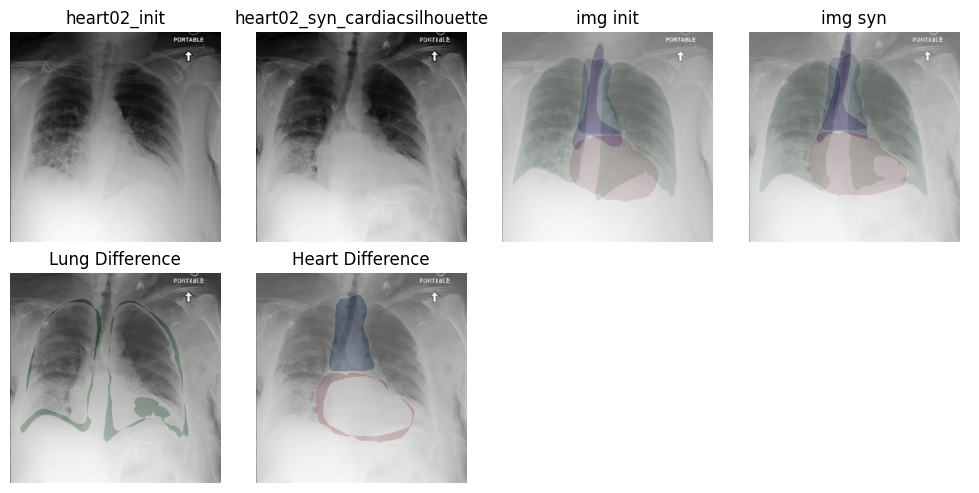

In [39]:
# load_name1 = "/media/NAS06/gavinyue/disentanglement/yingying_tasks/result1_select/89p10439781_s56498272_cbf70dce-197f82f4-7b8613a7-c0b0b099-d1de4726_init.png"
# load_name2 = "/media/NAS06/gavinyue/disentanglement/yingying_tasks/result1_select/89p10439781_s56498272_cbf70dce-197f82f4-7b8613a7-c0b0b099-d1de4726_remove_Enlarged Cardiomediastinum_0_r2gen.png"
id = 1
name1 = join(dataset.dir1,load_names1[id])
name2 = join(dataset.dir1,load_names2[id])
print(name1, name2)
img1 = preprocessing(name1)
img2 = preprocessing(name2)
lung_mask1, heart_mask1, add_mask1, add_mask11 = get_lung_heart_mask(img1,model)
lung_mask2, heart_mask2, add_mask2, add_mask22 = get_lung_heart_mask(img2,model)

img1 = (img1[0].cpu().numpy())
img2 = (img2[0].cpu().numpy())
print(img1.shape, img2.shape)


fig, axes = plt.subplots(2, 4, figsize=(10, 5))
ax = axes.ravel()
ax[0].imshow(img1, cmap='gray')
ax[0].set_title(splitext(load_names1[id])[0])
ax[1].imshow(img2, cmap='gray')
ax[1].set_title(splitext(load_names2[id])[0])

ax[2].imshow(img1, cmap='gray')
ax[2].imshow(lung_mask1, cmap='Greens', alpha=0.15)
ax[2].imshow(heart_mask1, cmap='Reds', alpha=0.15)
ax[2].imshow(add_mask1, cmap='Blues', alpha=0.15)
ax[2].imshow(add_mask11, cmap='Purples', alpha=0.15)
ax[2].set_title('img init')

ax[3].imshow(img2, cmap='gray')
ax[3].imshow(lung_mask2, cmap='Greens', alpha=0.15)
ax[3].imshow(heart_mask2, cmap='Reds', alpha=0.15)
ax[3].imshow(add_mask2, cmap='Blues', alpha=0.15)
ax[3].imshow(add_mask22, cmap='Purples', alpha=0.15)
ax[3].set_title('img syn')


diff_lung = np.bitwise_xor(lung_mask1, lung_mask2)
diff_heart = np.bitwise_xor(heart_mask1, heart_mask2)
diff_facies = np.bitwise_xor(add_mask1, add_mask2)
ax[4].imshow(img2,cmap='gray')
ax[4].imshow(diff_lung, cmap='Greens', alpha=0.2)
# ax[4].imshow(diff_facies, cmap='Blues', alpha=0.2)
ax[4].set_title("Lung Difference")
ax[5].imshow(img2,cmap='gray')
ax[5].imshow(diff_heart, cmap='Reds', alpha=0.2)
ax[5].imshow(add_mask2, cmap='Blues', alpha=0.2)
ax[5].set_title("Heart Difference")
for a in ax:
    a.axis('off')

plt.tight_layout()
# plt.savefig(f"seg_{splitext(load_names2[id])[0]}")

In [44]:
# Load the image
img1 = preprocessing(name1)
img2 = preprocessing(name2)
lung_mask1, heart_mask1, add_mask1, add_mask11 = get_lung_heart_mask(img1,model)
lung_mask2, heart_mask2, add_mask2, add_mask22 = get_lung_heart_mask(img2,model)

left_image = np.array(Image.open(name1))
right_image = np.array(Image.open(name2))

left_image = cv2.cvtColor(left_image, cv2.COLOR_BGR2GRAY)
right_image = cv2.cvtColor(right_image, cv2.COLOR_BGR2GRAY)

# save_dir = f"/media/NAS06/gavinyue/disentanglement/yingying_tasks/yyfang_result3/{splitext(load_names2[id])[0]}"
save_dir = join(img_dir.replace("imgs", "results"), splitext(load_names2[id])[0])
os.makedirs(save_dir, exist_ok=True)

Setting XRayResizer engine to cv2 could increase performance.
Setting XRayResizer engine to cv2 could increase performance.


32.0


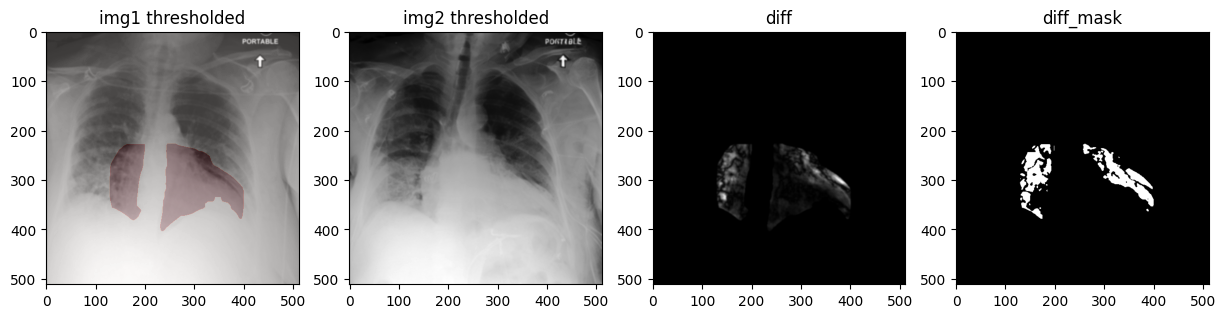

In [45]:
def get_diff_masks(img1, img2):
    assert len(img1.shape) == 2 and len(img2.shape) == 2, "Input images must be grayscale" 
                
    # Compute the absolute difference between the blurred images
    img1 = cv2.GaussianBlur(img1, (5, 5), 0)
    img2 = cv2.GaussianBlur(img2, (5, 5), 0)
    # threshold = 55
    # img1 = np.where(img1 > threshold, img1-threshold, 0)
    # img2 = np.where(img2 > threshold, img2-threshold, 0)
    diff = cv2.absdiff(img1, img2)

    # diff = cv2.absdiff(img1, img2)
    # diff = np.where(img1 > img2, img1-img2, 0)

    # # Remove shape artefactes (hollow and decreased edges)
    combined_mask = np.bitwise_or(lung_mask1, lung_mask2)
    # Erode the mask to make it smaller
    kernel = np.ones((5, 5), np.uint8)
    combined_mask = cv2.erode(combined_mask, kernel, iterations=2)
    heart_mask = np.bitwise_or(heart_mask1, heart_mask2)
    heart_mask = cv2.dilate(heart_mask, kernel, iterations=8)
    combined_mask = np.bitwise_and(combined_mask, heart_mask)
    
    # indices = np.where(combined_mask)
    # min_x, min_y = np.min(indices[0]), np.min(indices[1])
    # max_x, max_y = np.max(indices[0]), np.max(indices[1])
    # print(f"min_x: {min_x}, min_y: {min_y}, max_x: {max_x}, max_y: {max_y}")
    # combined_mask[int((min_x+max_x)/2):,:] = 0
    # combined_mask[:,int((min_y+max_y)/2):] = 0
    
    diff = cv2.bitwise_and(diff, diff, mask=combined_mask)

    
    # thre2 = int(np.percentile(diff, 95))
    # print(thre2)
    # thre2 = 15
    # diff = np.where(diff > thre2, diff-thre2, 0)

    # # normalise to [0,255] Useless!
    diff = cv2.normalize(diff, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    # Apply Gaussian Blur to reduce noise
    diff = cv2.GaussianBlur(diff, (5, 5), 0)
    # Apply Otsu's thresholding to get a binary mask
    # thre2 = int(np.percentile(diff, 95))
    # print(thre2)
    # diff = np.where(diff > thre2, diff-thre2, 0)
    a, diff_mask = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    print(a)
    
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    axes[0].imshow(img1, cmap='gray')
    axes[0].set_title("img1 thresholded")
    axes[0].imshow(combined_mask, cmap='Reds', alpha = 0.2)
    axes[1].imshow(img2, cmap='gray')
    axes[1].set_title("img2 thresholded")
    axes[2].imshow(diff, cmap='gray')
    axes[2].set_title("diff")
    axes[3].imshow(diff_mask, cmap='gray')
    axes[3].set_title("diff_mask")
    return diff_mask
img1 = left_image; img2 = right_image
get_diff_masks(img1, img2);

32.0
Mask Area: 12652, Min Area: 632.6
Component 1 has area 6205
Component 2 has area 6447
Intersection Area: 4444, Mask Area: 6447
Intersection Area: 4790, Mask Area: 6205


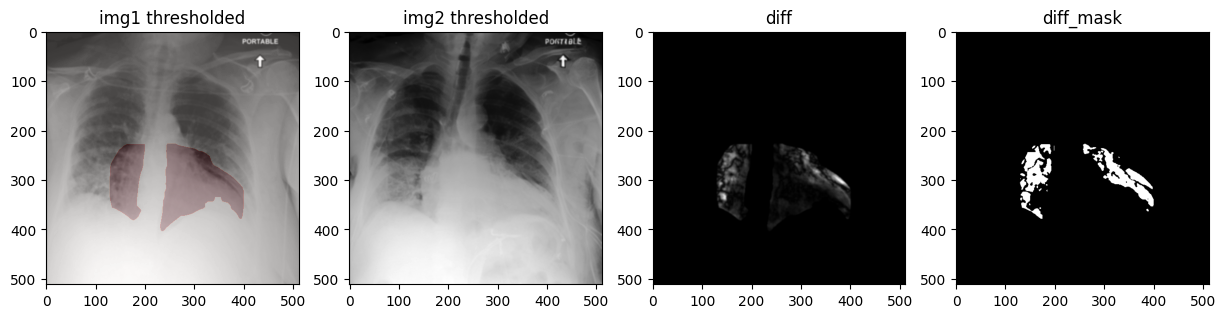

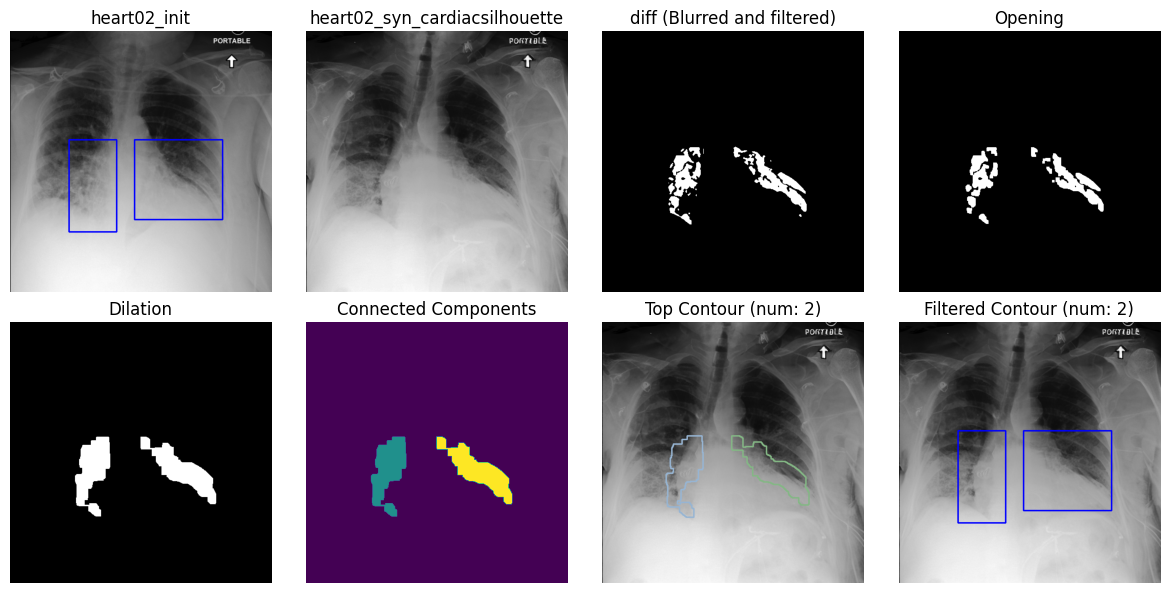

In [ ]:
# def get_diff_masks(img1, img2):
#     assert len(img1.shape) == 2 and len(img2.shape) == 2, "Input images must be grayscale" 
                
#     # Compute the absolute difference between the blurred images
#     img1 = cv2.GaussianBlur(img1, (5, 5), 0)
#     img2 = cv2.GaussianBlur(img2, (5, 5), 0)
#     threshold = np.percentile(img1, 25)
#     print(threshold)
    
#     # img1 = np.where(img1 < 100, img1, 0) #65 or 100
#     # img2 = np.where(img2 < 100, img2, 0)
#     img1 = np.where(img1 > 65, img1, 0) #65 or 100
#     img2 = np.where(img2 > 65, img2, 0)
#     diff = cv2.absdiff(img1, img2)


#     # # Remove shape artefactes (hollow and decreased edges)
#     # combined_mask = get_intersection_mask(img1, img2)
#     combined_mask = np.bitwise_or(lung_mask1, lung_mask2)
#     diff = cv2.bitwise_and(diff, diff, mask=combined_mask)

#     # # normalise to [0,255] Useless!
#     diff = cv2.normalize(diff, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
#     # Apply Gaussian Blur to reduce noise
#     diff = cv2.GaussianBlur(diff, (5, 5), 0)
#     # Apply Otsu's thresholding to get a binary mask
#     _, diff_mask = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#     return diff_mask

def get_boxes(img):
    contours = max(cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0], key=cv2.contourArea, default=None)
    if contours is None:
        print(f"Failed to find a box for input image")
        return None

    def draw_box(contour):
        x, y, w, h = cv2.boundingRect(contour)
        mx_start, mx_end = x  + int(w * 0.15), x  + int(w * 0.85)
        my_start, my_end = y + int(h * 0.15), y + int(h * 0.85)
        return (mx_start, my_start, mx_end - mx_start, my_end - my_start)

    middle_box = draw_box(contours)
    return np.array(middle_box)

def get_prompt_box(contour, offset=0):
    x, y, w, h = cv2.boundingRect(contour)
    mx_start, mx_end = x - int(offset/2), x  + int(w) + int(offset/2)
    my_start, my_end = y - int(offset/2), y + int(h) + int(offset/2)
    return np.array([mx_start, my_start, mx_end - mx_start, my_end - my_start])
    


import random
def get_fib_mask(orig_img, manip_img, show=False, middle_boxes=None, debug=False):
    diff_mask = get_diff_masks(orig_img, manip_img)
    # Step 2: Morphological Opening and Dilation
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(diff_mask, cv2.MORPH_OPEN, kernel, iterations=2)
    sure_fg = cv2.dilate(opening, kernel, iterations=3)
    sure_fg = cv2.morphologyEx(sure_fg, cv2.MORPH_CLOSE, kernel, iterations=4)

    # Step 3: Connected Component Analysis
    num_labels, labels_im = cv2.connectedComponents(sure_fg, connectivity=8)

    # Step 4: Filter Components
    # 4.1 Minimum Component is 3% of the mask area
    # 4.2 Sort components by area in descending order and select the top 8
    mask_area = cv2.countNonZero(sure_fg)
    min_area = mask_area * 0.05
    print(f"Mask Area: {mask_area}, Min Area: {min_area}")

    selected_mask = np.zeros_like(sure_fg)
    components = []
    for label in range(1, num_labels):
        component_mask = (labels_im == label).astype(np.uint8) * 255
        area = cv2.countNonZero(component_mask)
        if area >= min_area:
            components.append((area, component_mask))
            print(f"Component {label} has area {area}")
    
    components.sort(key=lambda x: x[0], reverse=True)
    top_components = components[:5]
    output_image = cv2.cvtColor(manip_img.copy(), cv2.COLOR_GRAY2BGR)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_GRAY2BGR)


    # mbox = get_boxes(manip_img)
    # # cv2.rectangle(output_image, (mbox[0], mbox[1]), (mbox[0] + mbox[2], mbox[1] + mbox[3]), (0, 0, 255), 2)
    # box_mask = np.zeros_like(manip_img, dtype=np.uint8)
    # cv2.rectangle(box_mask, (mbox[0], mbox[1]), (mbox[0] + mbox[2], mbox[1] + mbox[3]), 255, thickness=cv2.FILLED)
    # cv2.rectangle(output_image, (mbox[0], mbox[1]), (mbox[0] + mbox[2], mbox[1] + mbox[3]), (255, 0, 0), 2)
    heart_mask = np.bitwise_or(heart_mask1, heart_mask2)
    heart_mask = cv2.dilate(heart_mask, kernel, iterations=8)
    # combined_mask = np.bitwise_and(combined_mask, heart_mask)
    
    output_image1 = cv2.cvtColor(manip_img.copy(), cv2.COLOR_GRAY2BGR)
    for area, mask in top_components: 
    # Calculate the intersection of the selected mask with the box
        mask = cv2.GaussianBlur(mask, (5, 5), 0)
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        random_color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))# Draw contours with the random color
        cv2.drawContours(output_image1, contours, -1, random_color, 2)
        # cv2.drawContours(orig_img, contours, -1, random_color, 2)
    
    for area, mask in top_components: 
        # Calculate the intersection of the selected mask with the box
        intersection = cv2.bitwise_and(mask, heart_mask)
        intersection_area = cv2.countNonZero(intersection)
        print(f"Intersection Area: {intersection_area}, Mask Area: {cv2.countNonZero(mask)}")
        mask_area = cv2.countNonZero(mask)
        if intersection_area > 0.1 * mask_area:
        # if 1:
            selected_mask = cv2.bitwise_or(selected_mask, mask)
    
            mask = cv2.GaussianBlur(mask, (5, 5), 0)
            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) 
            random_color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))# Draw contours with the random color
            # cv2.drawContours(output_image, contours, -1, random_color, 2)
            
            for contour in contours:
                box = get_prompt_box(contour,offset=20)
                cv2.rectangle(output_image, (box[0], box[1]), (box[0] + box[2], box[1] + box[3]), (0, 0, 255), 2)
                # cv2.rectangle(orig_img, (box[0], box[1]), (box[0] + box[2], box[1] + box[3]), (0, 0, 255), 2)
            
    # Step 6: Contour Detection on Selected Components
    filter_contours, _ = cv2.findContours(selected_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    segmentation_mask = np.zeros_like(selected_mask, dtype=np.uint8)
    cv2.drawContours(segmentation_mask, filter_contours, -1, 255, thickness=cv2.FILLED)

    # Step 7: fill holes
    segmentation_mask = cv2.morphologyEx(segmentation_mask, cv2.MORPH_CLOSE, kernel, iterations=3)
    
    # if segmentation_mask.any() > 0:
    #     gt2D = segmentation_mask
    #     y_indices, x_indices = np.where(gt2D > 0)
    #     x_min, x_max = np.min(x_indices), np.max(x_indices)
    #     y_min, y_max = np.min(y_indices), np.max(y_indices)
    #     # add perturbation to bounding box coordinates
    #     H, W = gt2D.shape
    #     x_min = max(0, x_min - 20)
    #     x_max = min(W, x_max + 20)
    #     y_min = max(0, y_min - 20)
    #     y_max = min(H, y_max + 20)
    #     bbox = np.array([x_min, y_min, x_max, y_max])
    #     # cv2.rectangle(output_image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 0, 0), 2)
    
                
            
    if show:
        fig, axes = plt.subplots(2, 4, figsize=(12, 6)) 
        images = [orig_img, manip_img, diff_mask, opening]
        titles = [splitext(load_names1[id])[0], splitext(load_names2[id])[0], 'diff (Blurred and filtered)','Opening']
        for i, (img, title) in enumerate(zip(images, titles)):
            axes[0, i].imshow(img, cmap='gray')
            axes[0, i].set_title(title)
            plt.imsave(join(save_dir, f"{title}.png"), img, cmap='gray')
        
        images2 = [sure_fg, labels_im, output_image1, output_image]
        # titles2 = ['Dilation', 'Connected Components', f'Filtered Contour (num: {len(filter_contours)})', f'Segmentation Mask (num: {len(filter_contours)})']
        titles2 = ['Dilation', 'Connected Components', f'Top Contour (num: {len(top_components)})', f'Filtered Contour (num: {len(filter_contours)})']
        for i, (img, title) in enumerate(zip(images2, titles2)):
            # if i > 2:
            #     img = Image.fromarray(img)
            #     img.save(f"{splitext(load_names2[id])[0]}_box.png")
            axes[1, i].imshow(img, cmap='gray' if i != 1 else None)
            axes[1, i].set_title(title)
            plt.imsave(join(save_dir, f"{title}.png"), img, cmap='gray' if i != 1 else None)
        # axes[1, 2].imshow(diff_heart, cmap='Reds', alpha=0.2)

        # axes[1,2].imshow(heart_mask, cmap='Reds', alpha = 0.2)
        for ax in axes.flatten():
            ax.axis('off')
        plt.tight_layout()
        plt.savefig(join(save_dir, f"{splitext(load_names2[id])[0]}_compare.png"))
        plt.show()
    return output_image, segmentation_mask, len(top_components), len(filter_contours)

img1 = left_image; img2 = right_image
output_image, segmentation_mask, l1, l2 = get_fib_mask(img1, img2, show=True)


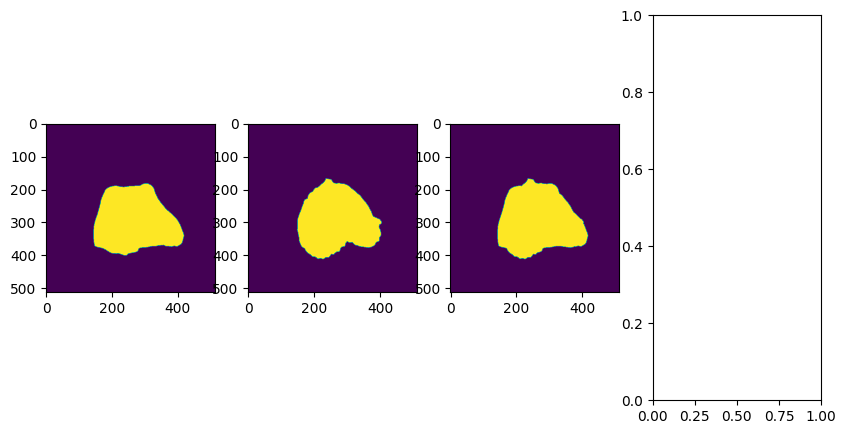

In [30]:
heart_mask = np.bitwise_or(heart_mask1, heart_mask2)
fig, ax = plt.subplots(1, 4, figsize=(10, 5))
ax[0].imshow(heart_mask1)
ax[1].imshow(heart_mask2)
ax[2].imshow(heart_mask)